In [33]:
import os
import random
import shutil
from pathlib import Path
from glob import glob

import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import kagglehub

In [34]:
# === Настройки ===
SOURCE_DIR = Path(kagglehub.dataset_download("chrisfilo/urbansound8k"))
OUTPUT_DIR = Path("datasets/audio")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

Using Colab cache for faster access to the 'urbansound8k' dataset.


In [35]:
TARGET_COUNT = 1000
AUG_CLASSES = ['class_1', 'class_6', 'class_8']

In [36]:
CLASSES = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music',
}

In [37]:
def copy_files_by_class(source_dir: Path, output_dir: Path):
    """Копируем файлы в папки по классам."""
    for folder in source_dir.glob("fold*"):
        for fpath in folder.glob("*.wav"):
            class_number = fpath.stem.split("-")[1]
            class_dir = output_dir / f"class_{class_number}"
            class_dir.mkdir(parents=True, exist_ok=True)
            shutil.copy2(fpath, class_dir / fpath.name)

In [38]:
def remove_silence(y, sr, top_db=25, hop_length=512):
    """Удаляем тишину из аудио."""
    intervals = librosa.effects.split(y, top_db=top_db, hop_length=hop_length)
    return np.concatenate([y[start:end] for start, end in intervals])

In [39]:
def process_audio_files(output_dir: Path):
  """Применяем очистку тишины ко всем файлам."""
  for class_folder in output_dir.glob("class_*"):
    print(f"Processing {class_folder}...")
    for fpath in class_folder.glob("*.wav"):
      y, sr = librosa.load(fpath, sr=None)
      y_clean = remove_silence(y, sr)
      sf.write(fpath, y_clean, sr)

In [40]:
def plot_class_distribution(output_dir: Path):
    """Строим график распределения файлов по классам."""
    class_counts = {folder.name: len(list(folder.glob("*.wav")))
                    for folder in output_dir.glob("class_*")}

    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_counts.keys(), class_counts.values(), edgecolor='black')

    for bar, count in zip(bars, class_counts.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
                 str(count), ha='center', va='bottom', fontsize=10)

    plt.xlabel("Класс")
    plt.ylabel("Количество файлов")
    plt.title("Распределение файлов по классам")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [41]:
def plot_class_distribution(output_dir: Path):
    """Строим график распределения файлов по классам."""
    class_counts = {folder.name: len(list(folder.glob("*.wav")))
                    for folder in output_dir.glob("class_*")}

    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_counts.keys(), class_counts.values(), edgecolor='black')

    for bar, count in zip(bars, class_counts.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
                 str(count), ha='center', va='bottom', fontsize=10)

    plt.xlabel("Класс")
    plt.ylabel("Количество файлов")
    plt.title("Распределение файлов по классам")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [42]:
def augment_audio(y, sr):
    """Аугментация: шум, pitch shift, time stretch."""
    augmented = []

    # шум
    augmented.append(y + 0.005 * np.random.randn(len(y)))

    # pitch shift
    augmented.append(librosa.effects.pitch_shift(y=y, sr=sr,
                                                 n_steps=random.choice([-2, -1, 1, 2])))

    # time stretch
    rate = random.choice([0.8, 1.2])
    stretched = librosa.effects.time_stretch(y=y, rate=rate)
    stretched = (stretched[:len(y)] if len(stretched) > len(y)
                 else np.pad(stretched, (0, len(y) - len(stretched))))
    augmented.append(stretched)

    return augmented

In [43]:
def apply_augmentation(output_dir: Path, aug_classes: list):
    """Применяем аугментацию к выбранным классам."""
    for class_folder in aug_classes:
        folder_path = output_dir / class_folder
        files = list(folder_path.glob("*.wav"))
        print(f"Аугментация для {class_folder}, файлов: {len(files)}")

        for fpath in files:
            y, sr = librosa.load(fpath, sr=None)
            for i, aug in enumerate(augment_audio(y, sr)):
                new_name = fpath.with_name(f"{fpath.stem}_aug{i}.wav")
                sf.write(new_name, aug, sr)

In [44]:
def balance_classes(output_dir: Path, target_count: int):
    """Балансировка классов до target_count."""
    for class_folder in output_dir.glob("class_*"):
        files = list(class_folder.glob("*.wav"))

        if len(files) > target_count:
            to_delete = len(files) - target_count
            remove_files = random.sample(files, to_delete)
            for f in remove_files:
                f.unlink()
            print(f"{class_folder.name}: удалено {to_delete}, осталось {target_count}")

        elif len(files) < target_count:
            print(f"{class_folder.name}: всего {len(files)}, нужно аугментировать")
        else:
            print(f"{class_folder.name}: ровно {target_count} — ок")

In [45]:
copy_files_by_class(SOURCE_DIR, OUTPUT_DIR)

In [46]:
process_audio_files(OUTPUT_DIR)

Processing datasets/audio/class_6...
Processing datasets/audio/class_9...
Processing datasets/audio/class_8...
Processing datasets/audio/class_5...
Processing datasets/audio/class_1...
Processing datasets/audio/class_3...
Processing datasets/audio/class_4...
Processing datasets/audio/class_2...
Processing datasets/audio/class_0...
Processing datasets/audio/class_7...


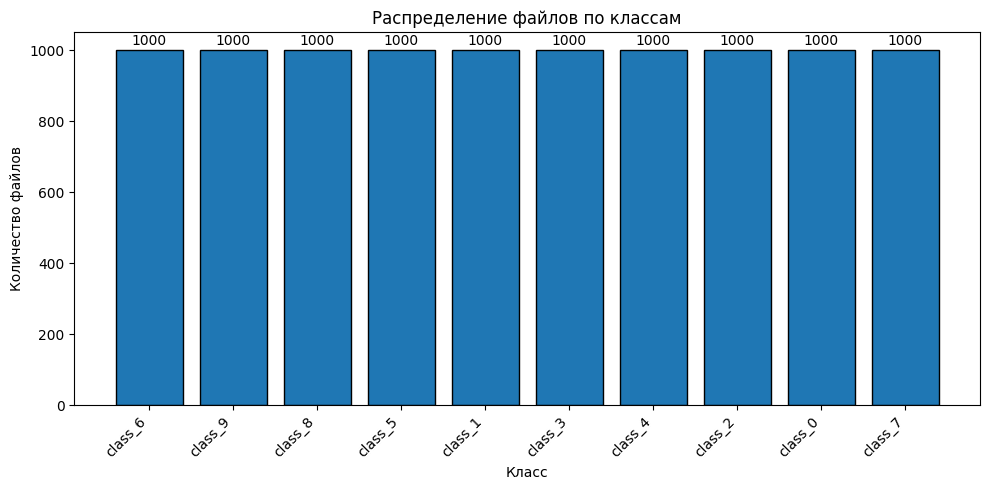

In [49]:
plot_class_distribution(OUTPUT_DIR)

In [17]:
apply_augmentation(OUTPUT_DIR, AUG_CLASSES)

Аугментация для class_1, файлов: 429
Аугментация для class_6, файлов: 374
Аугментация для class_8, файлов: 929


In [48]:
balance_classes(OUTPUT_DIR, TARGET_COUNT)

class_6: удалено 132, осталось 1000
class_9: ровно 1000 — ок
class_8: удалено 674, осталось 1000
class_5: ровно 1000 — ок
class_1: удалено 166, осталось 1000
class_3: ровно 1000 — ок
class_4: ровно 1000 — ок
class_2: ровно 1000 — ок
class_0: ровно 1000 — ок
class_7: ровно 1000 — ок


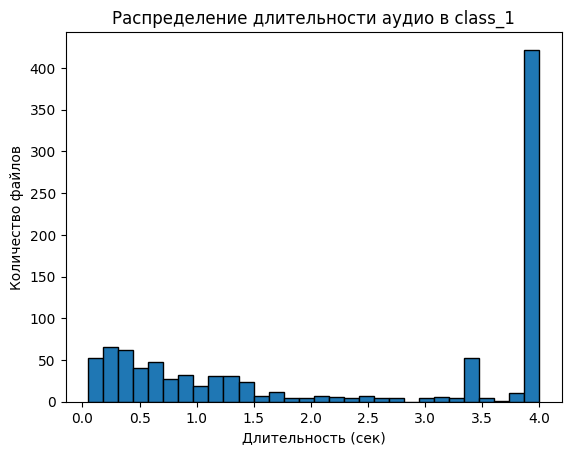

Средняя длительность: 2.38 сек
Максимальная: 4.00 сек
Минимальная: 0.05 сек


In [50]:
# посмотрим распределение по длительности аудио (на примере класса 1)
class_folder = os.path.join("datasets/audio/class_1")
files = glob(os.path.join(class_folder, "*.wav"))

durations = []
for fpath in files:
    y, sr = librosa.load(fpath, sr=None)
    durations.append(len(y) / sr)  # длина в секундах

plt.hist(durations, bins=30, edgecolor='black')
plt.xlabel("Длительность (сек)")
plt.ylabel("Количество файлов")
plt.title("Распределение длительности аудио в class_1")
plt.show()

print(f"Средняя длительность: {np.mean(durations):.2f} сек")
print(f"Максимальная: {np.max(durations):.2f} сек")
print(f"Минимальная: {np.min(durations):.2f} сек")


In [51]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

MAX_LEN = 4 * 22050  # 4 секунды при sr=22050
N_MFCC = 40

def extract_features(fpath, max_len=MAX_LEN, n_mfcc=N_MFCC):
    y, sr = librosa.load(fpath, sr=22050)
    # обрезаем/дополняем
    if len(y) > max_len:
        y = y[:max_len]
    else:
        y = np.pad(y, (0, max_len - len(y)))
    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # (time, features)

X, y_labels = [], []
class_map = {f"class_{i}": i for i in range(10)}

for class_folder in os.listdir("datasets/audio"):
    folder_path = os.path.join("datasets/audio", class_folder)
    files = glob(os.path.join(folder_path, "*.wav"))
    for fpath in files:
        feat = extract_features(fpath)
        X.append(feat)
        y_labels.append(class_map[class_folder])

X = np.array(X, dtype=object)  # список массивов разной длины
# выравниваем по max_len
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding="post", dtype="float32")
y_labels = np.array(y_labels)

# train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_labels, test_size=0.3, stratify=y_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(7000, 173, 40) (1500, 173, 40) (1500, 173, 40)


In [52]:
from tensorflow.keras import layers, models

num_classes = 10

model = models.Sequential([
    layers.Conv1D(64, kernel_size=5, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",       # можно также "val_accuracy"
    patience=5,               # сколько эпох ждать без улучшения
    restore_best_weights=True # вернёт лучшие веса
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,               # ставим максимум, например 100
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1560 - loss: 8.7065 - val_accuracy: 0.2053 - val_loss: 2.1155
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1739 - loss: 2.1801 - val_accuracy: 0.1800 - val_loss: 2.1633
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2434 - loss: 2.0528 - val_accuracy: 0.4913 - val_loss: 1.4686
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4788 - loss: 1.4725 - val_accuracy: 0.5733 - val_loss: 1.2363
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5743 - loss: 1.2453 - val_accuracy: 0.6340 - val_loss: 1.0963
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6263 - loss: 1.0573 - val_accuracy: 0.6693 - val_loss: 1.0169
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6910 - loss: 0.8948 - val_accuracy: 0.6873 - val_loss: 0.9208
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6916 - loss: 0.8441 - val_acc

Test accuracy: 0.834, Test loss: 0.702


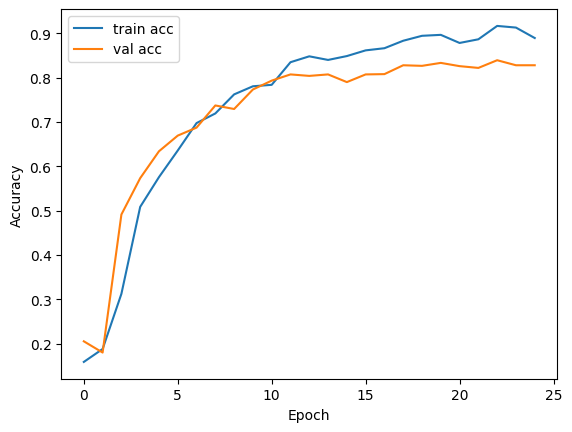

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f}, Test loss: {test_loss:.3f}")

# графики обучения
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Conv1D** ищет локальные шаблоны (лай собаки, сигнал сирены). Потом, как правило, идёт **Pooling** (например, MaxPooling), который берёт максимум из соседних значений, чтобы оставить только самые сильные признаки и уменьшить размер данных.

Precision (точность) — из всех предсказаний данного класса, какая доля оказалась правильной.
→ «Если модель сказала, что это dog_bark, то насколько часто она права».

Recall (полнота) — из всех реальных примеров данного класса, сколько модель правильно нашла.
→ «Из всех настоящих dog_bark, сколько модель поймала».

F1-score — гармоническое среднее между precision и recall. Баланс между точностью и полнотой.

Support — количество примеров данного класса в тестовой выборке.

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.75      0.95      0.84       150
        car_horn       0.91      0.91      0.91       150
children_playing       0.69      0.67      0.68       150
        dog_bark       0.85      0.66      0.74       150
        drilling       0.82      0.83      0.83       150
   engine_idling       0.94      0.83      0.88       150
        gun_shot       0.94      0.99      0.96       150
      jackhammer       0.93      0.87      0.90       150
           siren       0.91      0.82      0.86       150
    street_music       0.68      0.80      0.73       150

        accuracy                           0.83      1500
       macro avg       0.84      0.83      0.83      1500
    weighted avg       0.84      0.83      0.83      1500



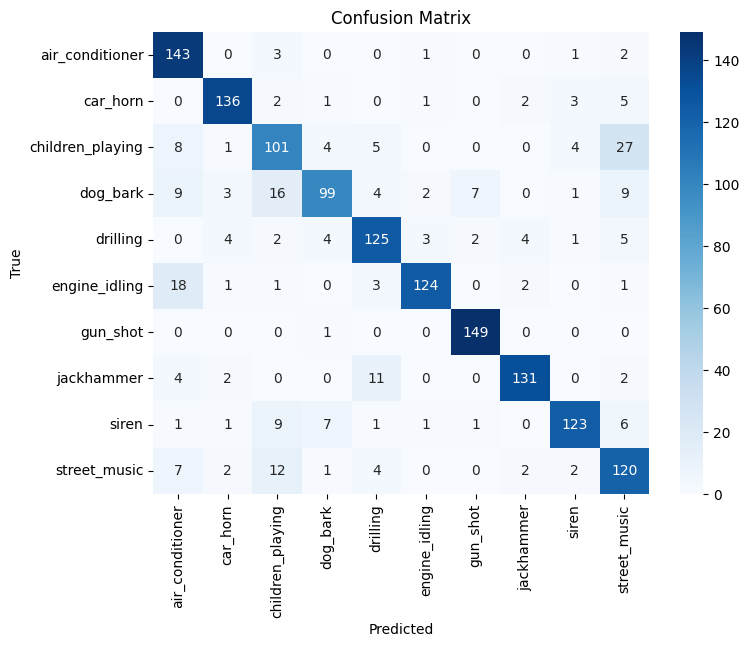

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# предсказания
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# отчёт по классам
print(classification_report(y_test, y_pred_classes, target_names=list(CLASSES.values())))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(CLASSES.values()),
            yticklabels=list(CLASSES.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


**Интерпретация:**

**air_conditioner:** precision 0.75, recall 0.95 → модель часто правильно находит кондиционер (почти все реальные примеры пойманы), но иногда путает его с другими классами.

**car_horn:** 0.91/0.91 → очень стабильный результат, модель хорошо различает автомобильные гудки.

**children_playing:** 0.69/0.67 → слабый результат, модель часто путает детскую игру с другими шумами.

**dog_bark: **precision 0.85, recall 0.66 → модель уверенно говорит «лай собаки», но пропускает часть настоящих примеров (низкий recall).

**drilling:** сбалансированные метрики ~0.83 → модель хорошо справляется.

**engine_idling:** высокая точность (0.94), но recall чуть ниже (0.83) → модель редко ошибается, но иногда не распознаёт двигатель.

**gun_shot:** почти идеальный результат (0.94/0.99/0.96) → модель отлично ловит выстрелы.

**jackhammer:** тоже высокий уровень (0.93/0.87/0.90).

**siren:** 0.91/0.82 → модель хорошо различает сирены, но иногда пропускает.

**street_music:** слабее (0.68/0.80/0.73) → модель часто путает музыку с другими классами.

In [58]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [60]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import pandas as pd

# meta = pd.read_csv(str(SOURCE_DIR / "UrbanSound8K.csv"))

# X, y, folds = [], [], []
# class_map = {f"class_{i}": i for i in range(10)}

# for class_folder in os.listdir("datasets/audio"):
#     folder_path = os.path.join("datasets/audio", class_folder)
#     files = glob(os.path.join(folder_path, "*.wav"))
#     for fpath in files:
#         fname = os.path.basename(fpath)
#         # если это аугментированный файл
#         if "_aug" in fname:
#           fold = -1   # специальная метка: всегда в train
#         else:
#           fold = meta.loc[meta['slice_file_name'] == fname, 'fold'].values[0]
#         feat = extract_features(fpath)
#         X.append(feat)
#         y.append(class_map[class_folder])
#         folds.append(fold)

# X = tf.keras.preprocessing.sequence.pad_sequences(np.array(X, dtype=object),
#                                                   padding="post", dtype="float32")
# y = np.array(y)
# folds = np.array(folds)

# results = []

# for fold_id in range(1, 11):
#     print(f"=== Fold {fold_id} ===")
#     train_idx = folds != fold_id
#     test_idx = folds == fold_id

#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]

#     # модель заново
#     model = models.Sequential([
#         layers.Conv1D(64, kernel_size=5, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
#         layers.MaxPooling1D(pool_size=2),
#         layers.Conv1D(128, kernel_size=5, activation="relu"),
#         layers.MaxPooling1D(pool_size=2),
#         layers.Flatten(),
#         layers.Dense(128, activation="relu"),
#         layers.Dropout(0.3),
#         layers.Dense(num_classes, activation="softmax")
#     ])

#     model.compile(optimizer="adam",
#                   loss="sparse_categorical_crossentropy",
#                   metrics=["accuracy"])

#     history = model.fit(X_train, y_train,
#                         validation_split=0.1,
#                         epochs=50,
#                         batch_size=32,
#                         callbacks=[early_stop],
#                         verbose=0)

#     y_pred = np.argmax(model.predict(X_test), axis=1)

#     acc = accuracy_score(y_test, y_pred)
#     prec = precision_score(y_test, y_pred, average="macro")
#     rec = recall_score(y_test, y_pred, average="macro")
#     f1 = f1_score(y_test, y_pred, average="macro")

#     results.append({"Fold": fold_id, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1})
#     print(f"Fold {fold_id}: acc={acc:.3f}, f1={f1:.3f}")

# # сводная таблица
# results_df = pd.DataFrame(results)
# print(results_df)
# print("Средние метрики:")
# print(results_df.mean())


=== Fold 1 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Fold 1: acc=0.274, f1=0.279
=== Fold 2 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Fold 2: acc=0.359, f1=0.359
=== Fold 3 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Fold 3: acc=0.361, f1=0.380
=== Fold 4 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Fold 4: acc=0.483, f1=0.477
=== Fold 5 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Fold 5: acc=0.346, f1=0.331
=== Fold 6 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Fold 6: acc=0.379, f1=0.374
=== Fold 7 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Fold 7: acc=0.386, f1=0.373
=== Fold 8 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Fold 8: acc=0.493, f1=0.496
=== Fold 9 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Fold 9: acc=0.482, f1=0.512
=== Fold 10 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Fold 10: acc=0.455, f1=0.437
   Fold  Accuracy  Precision    Recall        F1
0     1  0.274155   0.273841  0.379546  0.279259
1     2  0.359431   0.375966  0.459939  0.359107
2     3  0.360599   0.409266  0.443344  0.379504
3     4  0.482986   0.466514  0.513613  0.477013
4     5  0.346154   0.325888  0.428217  0.330885
5     6  0.378691   0.364910  0.447102  0.373801
6     7  0.385678   0.392899  0.398856  0.372779
7     8  0.492903   0.482376  0.563638  0.496461
8     9  0.481912   0.499039  0.564942  0.512203
9    10  0.455120   0.437305  0.507178  0.436959
Средние метрики:
Fold         5.500000
Accuracy     0.401763
Precision    0.402800
Recall       0.470638
F1           0.401797
dtype: float64


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
